# Pytorch Tensors

In [1]:
record = True
assert record, 'Записать встречу'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Напомню про тензоры и элементарные операции над ними
# https://drive.google.com/file/d/1pWhkJnRaVc9I7xr4X980v7lGKA6-oN2J/view?usp=share_link

CPU vs GPU

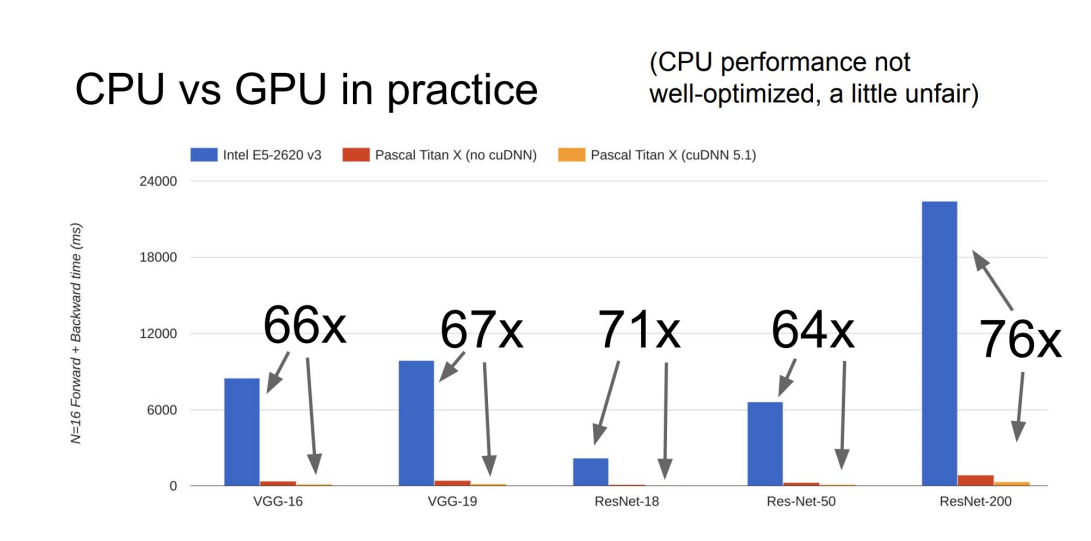

cuda vs cudann (has optimized implementations of Neural Net's operations)

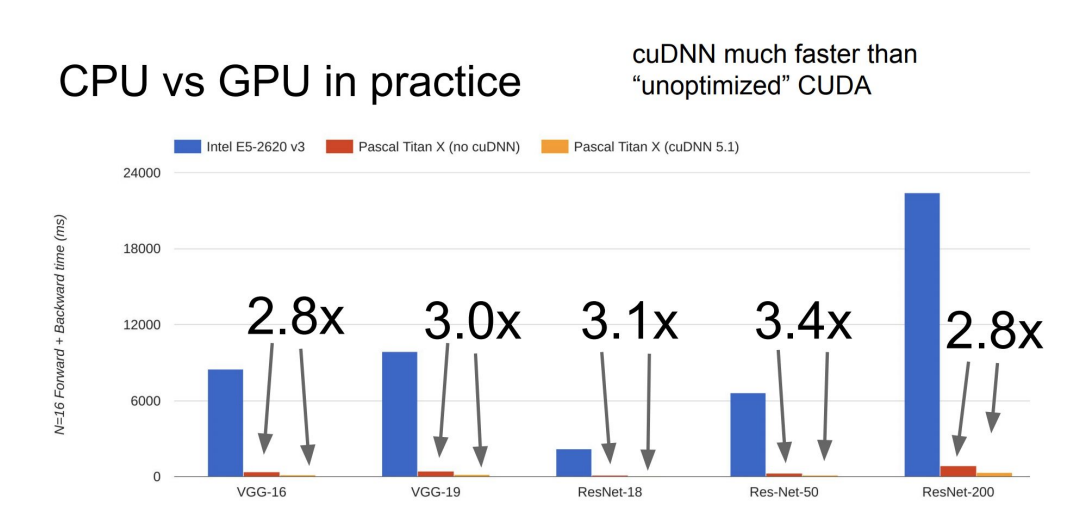

In [ ]:
import numpy as np
import torch

# Не всегда обоснованно исопользовать GPU с неольшими тензорами
# Время на передачу MEM -> GPU может быть дольше чем исполнение

# ДЗ: написать пример для такого случая

a = np.random.randint(0, 100, 1000)
b = np.random.randint(0, 100, 1000)

a_t = torch.randint(0, 100, (1000,))
b_t = torch.randint(0, 100, (1000,))

a * b; a_t * b_t;

In [3]:
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torchvision

## Пример numpy-like обучения простой модели

In [ ]:
# layer1 -> relu -> layer2 -> mse
# update weights

hidden_size = 100
num_examples = 64

dim_in = 1000
dim_out = 10

device = 'cpu' # 'cuda:0'

# Лучше сразу создавать тензоры на девайсе, чтобы избежать копирования на GPU (содаем сразу на GPU)
x = torch.randn(num_examples, dim_in, dtype=torch.float32, device=device)
y = torch.randn(num_examples, dim_out, dtype=torch.float32, device=device)

w1 = torch.randn(dim_in, hidden_size, dtype=torch.float32, device=device)
w2 = torch.randn(hidden_size, dim_out, dtype=torch.float32, device=device)


learning_rate = 1e-3

for step in range(500):
    # forward pass
    h = x.mm(w1) # first layer output
    relu_act = h.clamp(min=0) # max(0, x), first layer activations

    y_pred = relu_act.mm(w2) # second layer output

    loss = (y_pred - y).pow(2).sum() # mse loss


    # compute gradients
    grad_y_pred = 2.0 * (y_pred - y)

    grad_w2 = relu_act.t().mm(grad_y_pred)

    grad_h_relu = grad_y_pred.mm(w2.t())
    grad_h = grad_h_relu.clone()

    grad_h[h < 0] = 0
    grad_w1 = x.t().mm(grad_h)

    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2

# Есть струдности с пониманием backpropagation?
# Backprop micrograd: https://www.youtube.com/watch?v=VMj-3S1tku0
# Backprop ninja: https://www.youtube.com/watch?v=q8SA3rM6ckI&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=5

Torch from numpy

In [ ]:
a = np.ones(3)
a_t = torch.Tensor(a)
a[0] = 10
a, a_t

(array([10.,  1.,  1.]), tensor([1., 1., 1.]))

In [ ]:
a = np.ones(3)
a_t = torch.from_numpy(a)
a[0] = 10
a, a_t

(array([10.,  1.,  1.]), tensor([10.,  1.,  1.], dtype=torch.float64))

In [ ]:
a = np.ones(3)
a_t = torch.from_numpy(a)
a_t_numpy = a_t.numpy()
a[0] = 10
print(id(a_t_numpy), id(a))
a, a_t, a_t_numpy

140573953875568 140573953875280


(array([10.,  1.,  1.]),
 tensor([10.,  1.,  1.], dtype=torch.float64),
 array([10.,  1.,  1.]))

In [ ]:
a = np.ones(3)
a_t = torch.from_numpy(a) # cpu tensor
a_t_cuda = a_t.to('cuda:0')
print(type(a), type(a_t), type(a_t_cuda))
print(id(a_t), id(a_t_cuda))
a[0] = 10
a, a_t, a_t_cuda

<class 'numpy.ndarray'> <class 'torch.Tensor'> <class 'torch.Tensor'>
140573949108688 140573964661120


(array([10.,  1.,  1.]),
 tensor([10.,  1.,  1.], dtype=torch.float64),
 tensor([1., 1., 1.], device='cuda:0', dtype=torch.float64))

Copy vs Memory Sharing

In [ ]:
# Memory Sharing

# view, reshape, from_numpy, as_tensor не копируют данные тензора
t = torch.tensor((1, 2, 3, 4, 5, 6))
t_v  = t.view(2, 3)
t[0] = 10
print(t_v)
t

tensor([[10,  2,  3],
        [ 4,  5,  6]])


tensor([10,  2,  3,  4,  5,  6])

In [ ]:
# Memory Copy

# torch.tensor - определяет тип данных автоматически, но лучше писать явно
# torch.tensor(dtype=, device=) 
t = torch.tensor((1, 2, 3, 4, 5, 6))
t_d = t.float()
t[0] = 10
print(t)
t_d

tensor([10,  2,  3,  4,  5,  6])


tensor([1., 2., 3., 4., 5., 6.])

In [ ]:
# Memory Copy

# torch.Tensor - возвращает torch.FloatTensor 
t = torch.Tensor((1, 2, 3, 4, 5, 6))
t_d = t.float()
t[0] = 10
print(t)
t_d

tensor([10.,  2.,  3.,  4.,  5.,  6.])


tensor([1, 2, 3, 4, 5, 6])

GPU

In [ ]:
torch.cuda.is_available()

True

In [ ]:
# Не используйте .cuda() т к будет RuntimeError: No CUDA GPUs are available на машинах без девайса
# Нельзя контролироват девайс
# Используйте .to() и device= нотации
import torch
torch.tensor([1, 2]).cuda()

In [ ]:
# Нельзя миксовать тензоры с разных девайсов
# RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!
a = torch.randint(0, 10, (10,), device='cuda:0')
b = torch.randint(0, 10, (10,), device='cpu')
a * b

RuntimeError: ignored

Broadcasting

In [ ]:
x = torch.ones((5, 1, 4, 1))
y = torch.ones((5, 1, 4, 1))
(x + y).shape

torch.Size([5, 1, 4, 1])

In [ ]:
# Выходной вектор:
# Если x, y разный размер, добавляем единичную размерность в начало
# Идем по dim и выбираем максимум по размерностям
# (5, 1, 4, 1)
# (1, 7, 1, 3)
# (5, 7, 4, 3)

x = torch.ones((5, 1, 4, 1))
y = torch.ones((7, 1, 3))

(x + y).shape

torch.Size([5, 7, 4, 3])

In [ ]:
x = torch.tensor((3, 1))
print(x.shape)
x

torch.Size([2])


tensor([3, 1])

In [ ]:
y = torch.ones((2, 2))
y

tensor([[1., 1.],
        [1., 1.]])

In [ ]:
# (2, 2)
# (1, 2) boradcast x to become [[3, 1], [3, 1]]
# (2, 2)
x + y

tensor([[4., 2.],
        [4., 2.]])

In [ ]:
# Броадкаст на примере фичей
# (batch_size, steps, features)
# хотим взвесить фичи по весам w
x = torch.ones((2, 2, 3))
x[0, :] = x[0, :] * 0.5 # поменяли данные в первом батче 
w = torch.ones((3, 2))

res = x @ w
res.shape

torch.Size([2, 2, 2])

In [ ]:
x

tensor([[[0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000]],

        [[1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000]]])

In [ ]:
w

tensor([[1., 1.],
        [1., 1.],
        [1., 1.]])

In [ ]:
res

tensor([[[1.5000, 1.5000],
         [1.5000, 1.5000]],

        [[3.0000, 3.0000],
         [3.0000, 3.0000]]])

## Pytorch AutoGrad

In [ ]:
hidden_size = 100
num_examples = 64

dim_in = 1000
dim_out = 10

device = 'cpu' # 'cuda:0'

# Лучше сразу создавать тензоры на девайсе, чтобы избежать копирования на GPU (содаем сразу на GPU)
# Нет requires_grad, хотя ничего не мешает его добавить, будут для входных и выходных данных
# тоже градиенты считаться
x = torch.randn(num_examples, dim_in, dtype=torch.float32, device=device)
y = torch.randn(num_examples, dim_out, dtype=torch.float32, device=device)

w1 = torch.randn(dim_in, hidden_size, dtype=torch.float32, device=device, requires_grad=True)
w2 = torch.randn(hidden_size, dim_out, dtype=torch.float32, device=device, requires_grad=True)

# layer1 -> relu -> layer2 -> mse
# update weights

learning_rate = 1e-3

for step in tqdm(range(2)):
    h = x.mm(w1) # first layer output
    relu_act = h.clamp(min=0) # max(0, x), first layer activations

    y_pred = relu_act.mm(w2) # second layer output

    loss = (y_pred - y).pow(2).sum() # mse loss

    # compute gradient for w1, w2
    if w1.grad is not None: w1.grad.zero_() # inplace operation
    if w2.grad is not None: w2.grad.zero_() # inplace operation
    loss.backward()

    w1.data -= learning_rate * w1.grad.data
    w2.data -= learning_rate * w2.grad.data

    # TODO print loss

100%|██████████| 2/2 [00:00<00:00, 453.22it/s]


Autograd graph

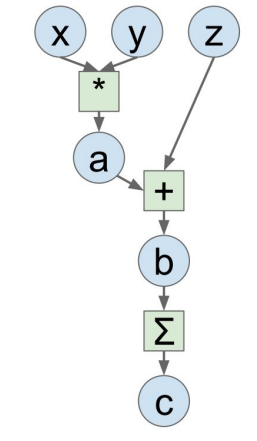

In [ ]:
x = torch.randn((2, 2), requires_grad=True)
y = torch.randn((2, 2), requires_grad=True)
z = torch.randn((2, 2), requires_grad=True)

a = x * y

b = z + a

b.retain_grad() # b не leaf-tensor, сохраним для него градиент

c = torch.sum(b)


# compute gradients
grad_c = 1 # dc/dc = 1

# градиент той же размерность что и b
grad_b = torch.ones((2, 2)) * grad_c # dc/db = [dc/db_1 * dc/dc, dc/db_2 * dc/dc, ...]

# + просто распространяет граденты дальше
# b = a + z; db/da = 1; db/dz = 1; dc/da = db/da * grad_b; dc/dz = db/dz * grad_b;
grad_a = grad_b.clone() 
grad_z = grad_b.clone()

# a = x * y; da/dx = y; da/dy = x;
grad_x = grad_a * y
grad_y = grad_a * x

In [ ]:
c.backward()
print(torch.equal(grad_z, z.grad.data))
print(torch.equal(grad_x, x.grad.data))
print(torch.equal(grad_y, y.grad.data))

In [ ]:
c
# Backprop micrograd: https://www.youtube.com/watch?v=VMj-3S1tku0
# Pytorch autograd: https://www.youtube.com/watch?v=MswxJw-8PvE

tensor(1.0607, grad_fn=<SumBackward0>)

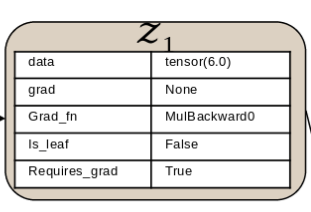

The .grad attribute of a Tensor that is not a leaf Tensor is being accessed.

In [ ]:
# Pytorch сохраняет градиеты только для leaf-tensors
# Это тензоры - которые не являются результатом операции над другими тензорами

In [ ]:
# вызвали retain_grad, поэтому есть градиент
print(torch.equal(grad_b, b.grad.data))

True


In [ ]:
# для с не отсавили градиент т к он результат операций над тензорами
c.grad

<ipython-input-30-47580c5f26b7>:2: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:480.)
  c.grad


In [ ]:
# Даже тут операция .to создает новый тензор, поэтому t уже не leaf-tensor
t = torch.rand(10, requires_grad=True).to('cuda:0')
a = torch.sum(t) + 10
a.backward()
t.grad

<ipython-input-31-96ba0916f167>:5: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:480.)
  t.grad


In [ ]:
# А так все ок, создаем тензор сразу на GPU
t = torch.rand(10, requires_grad=True, device='cuda:0')
a = torch.sum(t) + 10
a.backward()
t.grad

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')

loss.backward

In [ ]:
# когда loss - скаляр
t = torch.rand((2, 2), requires_grad=True)
loss = torch.sum(t)
loss.backward() 
t.grad

tensor([[1., 1.],
        [1., 1.]])

In [ ]:
t = torch.rand((2, 2), requires_grad=True)
# https://pytorch.org/docs/stable/generated/torch.nn.DataParallel.html
# например если loss с двух гпу от DataParallel
loss = torch.sum(t, dim=0) 
loss.backward() 
loss

In [ ]:
t = torch.rand((2, 2), requires_grad=True)
# https://pytorch.org/docs/stable/generated/torch.nn.DataParallel.html
# например если loss с двух гпу от DataParallel
loss = torch.sum(t, dim=0) 
loss.backward(torch.Tensor([1, 1])) 
loss

tensor([1.2459, 0.5358], grad_fn=<SumBackward1>)

# Pytorch High Level Abstractions

## Pytorch nn

In [ ]:
hidden_size = 100
num_examples = 64

dim_in = 1000
dim_out = 10

device = 'cpu' # 'cuda:0'

# Лучше сразу создавать тензоры на девайсе, чтобы избежать копирования на GPU (содаем сразу на GPU)
# Нет requires_grad, хотя ничего не мешает его добавить, будут для входных и выходных данных
# тоже градиенты считаться
x = torch.randn(num_examples, dim_in, dtype=torch.float32, device=device)
y = torch.randn(num_examples, dim_out, dtype=torch.float32, device=device)

model = nn.Sequential(
    nn.Linear(dim_in, hidden_size, bias=False),
    nn.ReLU(),
    nn.Linear(hidden_size, dim_out, bias=False)
)

criterion = nn.MSELoss(reduction='mean')

learning_rate = 1e-3

for step in tqdm(range(100)):
    y_pred = model(x)

    loss = criterion(y_pred, y) # pred, target

    model.zero_grad()
    loss.backward()

    for param in model.parameters(): 
        param.data -= learning_rate * param.grad.data

100%|██████████| 100/100 [00:00<00:00, 1158.05it/s]


In [ ]:
model

Sequential(
  (0): Linear(in_features=1000, out_features=100, bias=False)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=10, bias=False)
)

In [ ]:
for p in model.parameters():
    print(p.shape)

torch.Size([100, 1000])
torch.Size([10, 100])


In [ ]:
l1 = model[0]
l2 = model[2]
l1, l2

(Linear(in_features=1000, out_features=100, bias=False),
 Linear(in_features=100, out_features=10, bias=False))

In [ ]:
l1.weight

Parameter containing:
tensor([[-0.0107,  0.0081,  0.0048,  ..., -0.0098,  0.0115,  0.0167],
        [ 0.0198,  0.0088, -0.0084,  ..., -0.0315, -0.0275, -0.0156],
        [ 0.0093, -0.0308,  0.0242,  ..., -0.0091, -0.0115, -0.0287],
        ...,
        [-0.0212, -0.0236, -0.0062,  ...,  0.0277,  0.0130,  0.0264],
        [ 0.0280,  0.0302, -0.0122,  ...,  0.0060, -0.0088, -0.0226],
        [ 0.0228,  0.0074,  0.0104,  ...,  0.0182,  0.0251, -0.0171]],
       requires_grad=True)

In [ ]:
new_linear = nn.Linear(dim_in, hidden_size)
new_linear.bias.shape, new_linear.weight.shape

(torch.Size([100]), torch.Size([100, 1000]))

In [ ]:
list(l1.parameters()) # requires_grad=True

[Parameter containing:
 tensor([[-0.0107,  0.0081,  0.0048,  ..., -0.0098,  0.0115,  0.0167],
         [ 0.0198,  0.0088, -0.0084,  ..., -0.0315, -0.0275, -0.0156],
         [ 0.0093, -0.0308,  0.0242,  ..., -0.0091, -0.0115, -0.0287],
         ...,
         [-0.0212, -0.0236, -0.0062,  ...,  0.0277,  0.0130,  0.0264],
         [ 0.0280,  0.0302, -0.0122,  ...,  0.0060, -0.0088, -0.0226],
         [ 0.0228,  0.0074,  0.0104,  ...,  0.0182,  0.0251, -0.0171]],
        requires_grad=True)]

In [ ]:
# Посмотрим на все разнообразие операций: # https://pytorch.org/docs/stable/nn.html

## Optimizer

In [ ]:
hidden_size = 100
num_examples = 64

dim_in = 1000
dim_out = 10

device = 'cpu' # 'cuda:0'

# Лучше сразу создавать тензоры на девайсе, чтобы избежать копирования на GPU (содаем сразу на GPU)
# Нет requires_grad, хотя ничего не мешает его добавить, будут для входных и выходных данных
# тоже градиенты считаться
x = torch.randn(num_examples, dim_in, dtype=torch.float32, device=device)
y = torch.randn(num_examples, dim_out, dtype=torch.float32, device=device)

model = nn.Sequential(
    nn.Linear(dim_in, hidden_size, bias=False),
    nn.ReLU(),
    nn.Linear(hidden_size, dim_out, bias=False)
)

criterion = nn.MSELoss(reduction='mean')

learning_rate = 1e-3

# https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# можно и не все праметры: layer1.parameters()
# optimizer = torch.optim.AdamW(model[0].parameters(), lr=learning_rate)

# 1, 2, 3

for step in tqdm(range(100)):
    y_pred = model(x)

    loss = criterion(y_pred, y) # pred, target  

    model.zero_grad()
    loss.backward()

    optimizer.step() # update all parameters in the model

100%|██████████| 100/100 [00:00<00:00, 761.02it/s]


С оптимизацией разобрались

## Dataset, Dataloader

Теперь надо разобраться с поставкой данных

In [ ]:
# Абстракции обучения

'''
#Стадии обучения (например мы файнтюним модель)
for stage in stages:
    # Эпохи обучения
    for epoch in range(training_epochs):
        # Проход по всем тренировочным данным
        for batch in batches:
'''

# одна стадия - этап обучения с зафиксированным состоянием гиперпараметров, модели и т д
# одна эпоха - проходим по всем тренировочным данным один раз
# один батч - подвыборка из тренировочного датасета для обновления параметров модели 

In [ ]:
from torchvision import datasets, transforms

train_dateset = datasets.MNIST('./data', train=True, download=True,
                         transform=transforms.Compose([
                            transforms.ToTensor(), # [0, 1]
                            transforms.Normalize((0.1307,), (0.3081,))
                         ]))
train_loader = torch.utils.data.DataLoader(train_dateset, batch_size=16, shuffle=True)

test_dateset = datasets.MNIST('./data', train=False, download=True,
                         transform=transforms.Compose([
                            transforms.ToTensor(), # [0, 1]
                            transforms.Normalize((0.1307,), (0.3081,))
                         ]))

test_loader = torch.utils.data.DataLoader(test_dateset, batch_size=1, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
# https://www.kaggle.com/datasets/swaroopkml/cifar10-pngs-in-folders
!unzip -qq /content/drive/MyDrive/cifar_dataset.zip

In [5]:
import glob
import pandas as pd
from sklearn import preprocessing

labels = ['cat', 'dog', 'mouse', 'elephant', 'pandas']
le = preprocessing.LabelEncoder()
targets = le.fit_transform(labels)

# Создадим датафрейм для упрощения работы с данными
df = pd.DataFrame({'image': glob.glob('/content/cifar10/cifar10/*/*/*.png')})
df['label'] = df['image'].apply(lambda p: p.split('/')[-2])
df['split'] = df['image'].apply(lambda p: p.split('/')[-3])
df['int_label'] = le.fit_transform(df['label'])

len(df)
print(df.int_label.value_counts())
print(df.label.value_counts())
print(df.split.value_counts())

df.head(5)

1    6000
2    6000
0    6000
8    6000
5    6000
6    6000
3    6000
4    6000
7    6000
9    6000
Name: int_label, dtype: int64
automobile    6000
bird          6000
airplane      6000
ship          6000
dog           6000
frog          6000
cat           6000
deer          6000
horse         6000
truck         6000
Name: label, dtype: int64
train    50000
test     10000
Name: split, dtype: int64


image       label  split  \
0  /content/cifar10/cifar10/train/automobile/2879...  automobile  train   
1  /content/cifar10/cifar10/train/automobile/4806...  automobile  train   
2  /content/cifar10/cifar10/train/automobile/1508...  automobile  train   
3  /content/cifar10/cifar10/train/automobile/2383...  automobile  train   
4  /content/cifar10/cifar10/train/automobile/2097...  automobile  train   

   int_label  
0          1  
1          1  
2          1  
3          1  
4          1

In [6]:
from torch.utils.data import Dataset
from PIL import Image
from typing import Tuple
from torchvision.transforms import transforms


# Pytorch data tutorials: 
# 1. https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
# 2. https://pytorch.org/docs/stable/data.html


class DatasetTemplate(Dataset):
    """One data point abstraction."""
    def __init__(self):
        """Prepare data (read, download, prepare transforms etc.)"""
        pass
    
    def __getitem__(self, index):
        """Return single data point (inputs and targets)"""
        pass
    
    def __len__(self):
        """Return data length"""
        pass 

class CifarDataset(Dataset):
    
    def __init__(self, df: pd.DataFrame, mode='train', transforms=None):
        self.df = df[df.split == mode]
        self.transforms = transforms
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        # Нужно пытаться сделать извлечение элеманта максимально быстро
        # Пример: можно заранее порезать большие изображения на патчи
        row = self.df.iloc[index, :]
        image = Image.open(row['image'])
        label = row['int_label']

        if self.transforms:
            # аугментируем изображения на CPU
            image = self.transforms(image)

        # Не рекомендуется перекидывать данные на GPU в Dataset!
        return image, label
    
    def __len__(self):
        return len(self.df)


# DataLoader sample indexes using __getitem__
# torch.utils.data.Dataset: https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Dataset

# DataLoader call next() on dataset
# torch.utils.data.IterableDataset: https://medium.com/speechmatics/how-to-build-a-streaming-dataloader-with-pytorch-a66dd891d9dd

In [7]:
transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), 
                                 (0.2023, 0.1994, 0.2010)),
        ])

dataset = CifarDataset(df, transforms=transform)
dir(dataset)

['__add__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_is_protocol',
 'df',
 'transforms']

In [8]:
len(dataset)

50000

In [9]:
# перегрузка __getitem__
image, label = dataset[10]
image.shape, label

(torch.Size([3, 32, 32]), 1)

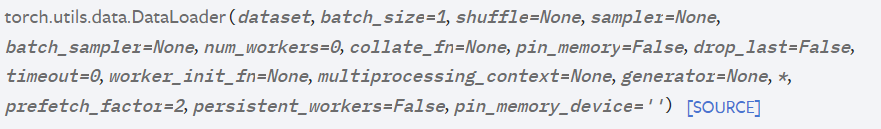

In [ ]:
# DataLoader: https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.DataLoader
# Абстракция, которая позволяет перейти от single datapoint к батчам для обучения модели
train_loader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=16,
    shuffle=True,
    sampler=None, # Можем задать различные способы извлечения данных из датасета (например для решения дизбаланса классов)
    drop_last=True,
    num_workers=2, # Можно тюнить для лучшего перфоманса (pytorch сам подсказывает сколько надо)
    prefetch_factor=2, # Воркеры могут заранее загрузить батчи
    pin_memory=True,
)

# Data Transfers Cuda: https://developer.nvidia.com/blog/how-optimize-data-transfers-cuda-cc/

In [ ]:
batch = next(iter(train_loader))
images, labels = batch
images.shape, labels

(torch.Size([16, 3, 32, 32]),
 tensor([7, 4, 6, 1, 6, 4, 6, 2, 4, 9, 0, 7, 2, 4, 4, 6]))

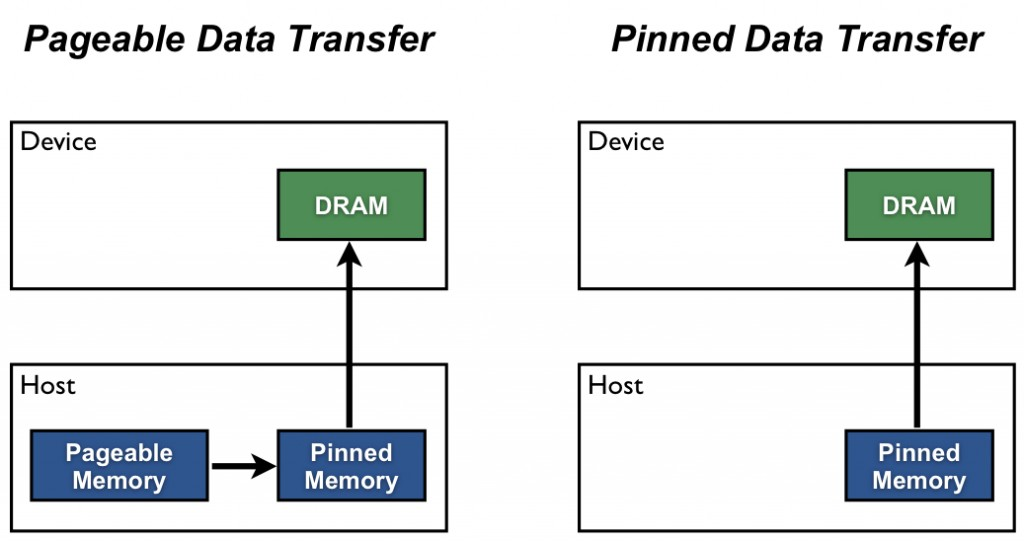

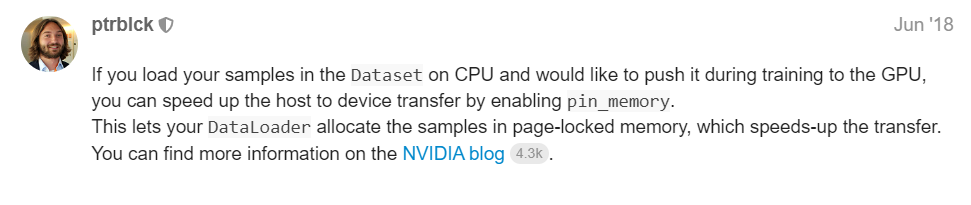

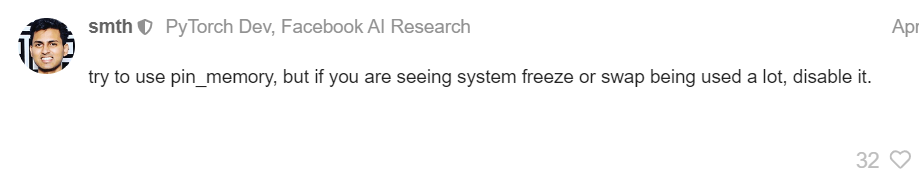

drop_last=True - не хотим делать апдейт весов на маленьком батче (BatchNorm это не одобрит), да и cudnn тоже

shuffle=False на тренировочных данных может приводить к интересным эффектам

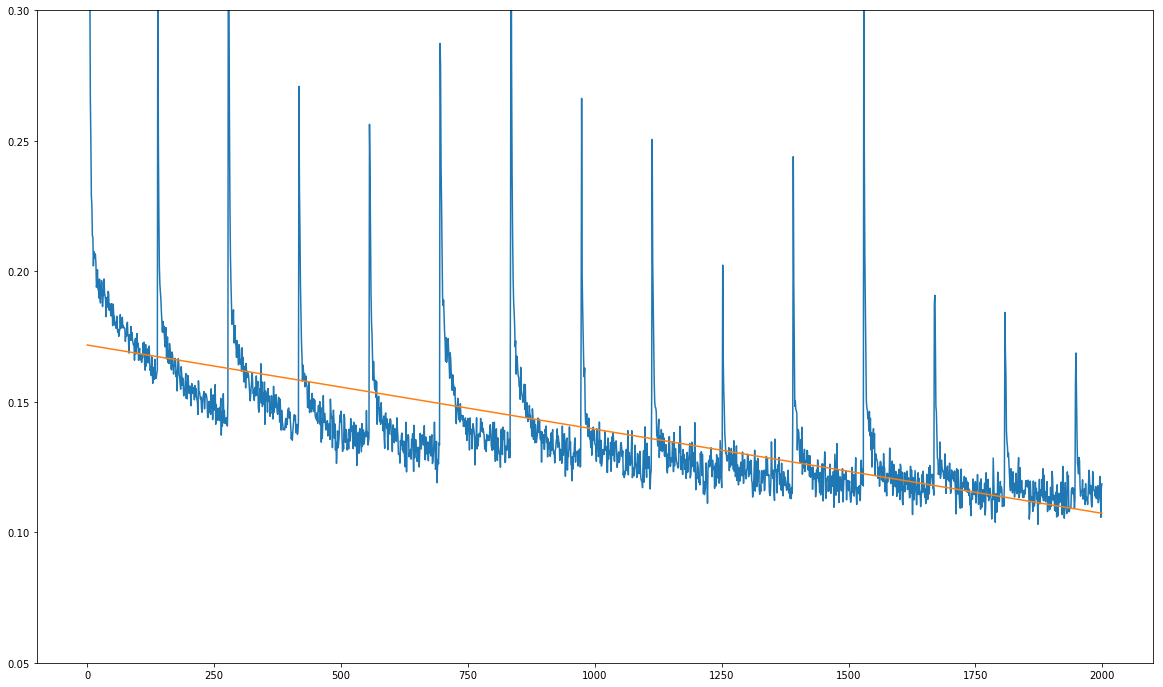

IO bound 

In [ ]:
# лучше SSD чем HDD
# если можно, загружаем все в оперативу
# режим больштие изображения на части заранее
# Можно использовать torchprofiler, чтобы определить что тормозит обучение:
# https://telegra.ph/Profilirovshchik-torchprofiler-10-23

# Если ботлнек в агументациях, можно поробовать делать их на гпу

# torchvision: https://pytorch.org/vision/stable/auto_examples/plot_scripted_tensor_transforms.html
# transforms = torch.nn.Sequential(
#     T.RandomCrop(224),
#     T.RandomHorizontalFlip(p=0.3),
# )

# kornia: https://kornia.readthedocs.io/en/v0.4.1/tutorials/data_augmentation.html
# transform = nn.Sequential(
#     kornia.enhance.AdjustBrightness(0.5),
#     kornia.enhance.AdjustGamma(gamma=2.),
#     kornia.enhance.AdjustContrast(0.7),
# )

# images = sample_batched['images'].to(device)
# labels = sample_batched['labels'].to(device)

# # perform the transforms
# images = transform(images)
# labels = transform(labels)

# Оба варианта умеют работать с батчами

## Собираем все вместе на примере Cifar

Model

In [11]:
import torch.nn.functional as F


class SimpleCNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=1)
        self.pool = nn.MaxPool2d(3, 2)
        self.dropout = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(in_features=128, out_features=1000)
        self.fc2 = nn.Linear(in_features=1000, out_features=10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.conv1(x))
        x = self.dropout(x)
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        bs, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        out = self.fc2(x)
        return out


model = SimpleCNN()
# (batch_size, channels, height, width)
model(torch.ones(2, 3, 128, 128)).shape

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


torch.Size([2, 10])

Data

In [12]:
transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), 
                                 (0.2023, 0.1994, 0.2010)),
        ])
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), 
                         (0.2023, 0.1994, 0.2010)),
])

train_dataset = CifarDataset(df, mode='train', transforms=transform)
test_dataset = CifarDataset(df, mode='test', transforms=transform)

train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=128,
    shuffle=True,
    drop_last=True,
    num_workers=2,
    pin_memory=True,
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=1,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)

# https://github.com/google-research/tuning_playbook

In [13]:
from tqdm import tqdm
import torch
from typing import Callable


def train_one_epoch(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: Callable,
) -> Tuple[float, float]:

    # помним, что некоторые модули ведут себя по разному во время инференса и обучения
    # например Dropout, BatchNormalization
    model.train() 

    train_running_loss = 0.0
    train_running_correct = 0
    total_epoch_steps = int(len(dataloader.dataset)/dataloader.batch_size)

    for _, batch in tqdm(enumerate(dataloader), total=total_epoch_steps):
        images, target = batch
        images, target = images.to(device), target.to(device)
        outputs = model(images)
        
        loss = criterion(outputs, target)
        train_running_loss += loss.item()

        _, preds = torch.max(outputs.data, 1) # можем не использовать softmax, а просто взять .max
        train_running_correct += (preds == target).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss/len(dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(dataloader.dataset)    
    return train_loss, train_accuracy


def validate(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader
):

    model.eval()

    val_running_loss = 0.0
    val_running_correct = 0

    with torch.no_grad(): # Не нужно считать градиенты (+ к скорости инференса и - потребление памяти)
        inference_steps = int(len(dataloader.dataset)/dataloader.batch_size)

        for _, batch in tqdm(enumerate(dataloader), total=inference_steps):
            
            images, target = batch
            images = images.to(device)
            target = target.to(device)

            outputs = model(images)
            loss = criterion(outputs, target)
            
            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == target).sum().item()
        
        val_loss = val_running_loss/len(dataloader.dataset)
        val_accuracy = 100. * val_running_correct/len(dataloader.dataset)        
        return val_loss, val_accuracy


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = SimpleCNN().to(device)
learning_rate = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [14]:
for param_tensor in model.state_dict():
    print(f"{param_tensor} \t {model.state_dict()[param_tensor].size()}")
for var_name in optimizer.state_dict():
    print(f"{var_name} \t {optimizer.state_dict()[var_name]}")

conv1.weight 	 torch.Size([64, 3, 5, 5])
conv1.bias 	 torch.Size([64])
conv2.weight 	 torch.Size([64, 64, 5, 5])
conv2.bias 	 torch.Size([64])
conv3.weight 	 torch.Size([128, 64, 5, 5])
conv3.bias 	 torch.Size([128])
fc1.weight 	 torch.Size([1000, 128])
fc1.bias 	 torch.Size([1000])
fc2.weight 	 torch.Size([10, 1000])
fc2.bias 	 torch.Size([10])
state 	 {}
param_groups 	 [{'lr': 0.0001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0.01, 'amsgrad': False, 'foreach': None, 'maximize': False, 'capturable': False, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]


In [15]:
train_loss , train_accuracy = [], []

epochs = 1

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy = train_one_epoch(model, train_loader, optimizer, criterion)

    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)

    print(f"Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_accuracy:.2f}")

    val_loss, val_accuracy = validate(model, test_loader)
    print(f"Test Loss: {val_loss:.4f}, Test Acc: {val_accuracy:.2f}")

Epoch 1 of 1


100%|██████████| 390/390 [04:13<00:00,  1.54it/s]

Train Loss: 0.0156, Train Acc: 25.73



100%|██████████| 10000/10000 [01:22<00:00, 121.08it/s]

Test Loss: 1.7044, Test Acc: 37.98


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
 
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Воспроизводимость и Resume Training

REPRODUCIBILITY

In [10]:
# Различия все же будут, если запустить один процесс на GPU, другой на процесс CPU
# REPRODUCIBILITY: https://pytorch.org/docs/stable/notes/randomness.html
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True 
    # будет работать - если граф вычислений не будет меняться во время обучения
    torch.backends.cudnn.benchmark = True # оптимизации
seed_everything(1234)

Resume training

In [ ]:
current_epoch = 10
save_path = './checkpoint/model.ckpt'


torch.save({
    'epoch': current_epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, save_path)

In [ ]:
checkpoint = torch.load(save_path)
model_loaded.load_state_dict(checkpoint['model_state_dict'])
optimizer_loaded.load_state_dict(checkpoint['optimizer_state_dict'])
epoch_loaded = checkpoint['epoch']
# https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [ ]:
# ДЗ: проверить resume_training

## Проверка Resume Training

В ходе обучения мы увидели, что  Loss: 1.7044, Test Acc: 37.98

In [16]:
current_epoch = 2
save_path = '/content/checkpoint/model.ckpt'


torch.save({
    'epoch': current_epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, save_path)

In [17]:
weights_before_save = list(model.parameters()) # Сохраняем веса модели

In [18]:
model = SimpleCNN() # отчищаем модель

In [19]:
checkpoint = torch.load(save_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
# https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [20]:
val_loss, val_accuracy = validate(model, test_loader)
print(f"Test Loss: {val_loss:.4f}, Test Acc: {val_accuracy:.2f}")


100%|██████████| 10000/10000 [01:27<00:00, 114.17it/s]

Test Loss: 1.7077, Test Acc: 37.75


In [21]:
val_loss, val_accuracy = validate(model, test_loader)
print(f"Test Loss: {val_loss:.4f}, Test Acc: {val_accuracy:.2f}")

100%|██████████| 10000/10000 [01:27<00:00, 114.46it/s]

Test Loss: 1.7035, Test Acc: 38.15


In [22]:
val_loss, val_accuracy = validate(model, test_loader)
print(f"Test Loss: {val_loss:.4f}, Test Acc: {val_accuracy:.2f}")

100%|██████████| 10000/10000 [01:23<00:00, 119.70it/s]

Test Loss: 1.7051, Test Acc: 37.60


Значения похожие, но, наверное, присутствует какой-то рандом и `seed_everything(1234)` не помогло. Для того, чтобы проверить действительно ли модели одинаковые нужно сравнить веса.

In [26]:
weights_after_saving = list(model.parameters())

In [30]:
equals = True
for i, j in zip(weights_after_saving, weights_before_save):
  equals = equals and torch.all(torch.eq(i, j))
print(equals)

tensor(True)


Так как веса равны, то модели одинаковые